In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pandas import DataFrame
from QuantLib import Actual360
from QuantLib import Period
from QuantLib import QuoteHandle
from QuantLib import SimpleQuote
from QuantLib import SwaptionHelper
from QuantLib import Years
from collections import namedtuple
import math
from pandas import DataFrame

import pandas as pd
from hull_white_callibration import create_swaption_helpers
from hull_white_callibration import calibration_report

In [3]:
from hacksad.misc import today

date = today()
date = today() - pd.Timedelta(days=2)

In [4]:
from backtestad.instruments.bonds.universe import BondUniverse
from backtestad.backtest.declarators.declarator import BacktesterDeclarator

container = BacktesterDeclarator(
    pd.Timestamp("2020-01-01"),
    today(),
    bond_universe=BondUniverse(
        country=("RU",),
        security_type=(
            "Корп",
            "Гос",
        ),
        ccy=("RUB",),
    ),
)

container.current_date = date
from backtestad.instruments.bonds.bond import Bond

bond = container.instruments.bond("RUB", "face_isin")

In [5]:
nss_curve = bond._curve_data.get_ql_curve(today())

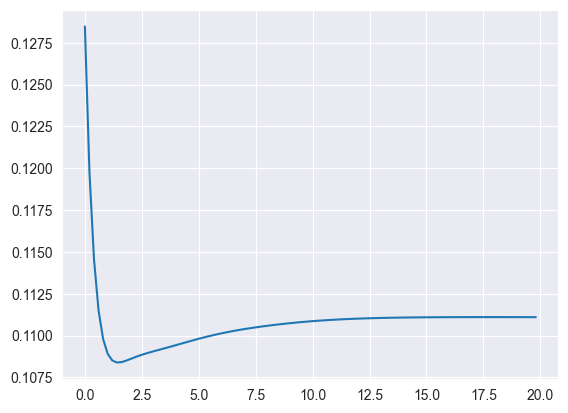

In [18]:
from matplotlib import pyplot as plt
import numpy as np

mat = np.arange(0, 20, 0.2)
plt.plot(mat, bond._curve_data.risk_free_curve(mat))

In [6]:
from dataclasses import dataclass
import pandas as pd
import QuantLib as ql
from QuantLib import Settings
from hacksad.misc import today


ql_today = ql.Date(date.day, date.month, date.year)
settlement = date + pd.Timedelta(weeks=53 * 10)
settlement = ql.Date(settlement.day, settlement.month, settlement.year)
ql.Settings.instance().evaluationDate = ql_today
term_structure = ql.YieldTermStructureHandle(
    nss_curve
    # ql.FlatForward(settlement, 0.04875825, ql.Actual365Fixed())
)
# index  = term_structure
index = ql.Euribor1Y(term_structure)


@dataclass
class CalibrationData:
    start: ql.Date  # maturity
    length: ql.Period  # length
    volatility: float

In [7]:
index

<QuantLib.QuantLib.Euribor1Y; proxy of <Swig Object of type 'ext::shared_ptr< Euribor1Y > *' at 0x177bdda10> >

In [8]:
from irm.swaption import get_swaption_volatility_data

import pandas as pd

from backtestad.db.sql.interest_rates import get_rate


volatility = get_swaption_volatility_data().dropna()

In [9]:
date

Timestamp('2023-11-24 00:00:00')

In [36]:
# data = [
#     CalibrationData(
#         ql.Date(date.day, date.month, date.year), ql.Period(tenor), vola
#     )
#     for tenor, vola in volatility.reset_index(["tenor"]).values
# ]

external_val = {
    "01M": 5.9485365479539505,
    "01W": 4.878324208851185,
    "01Y": 3.3278370903047803,
    "02M": 5.537561945271509,
    "02Y": 1.6119216950112998,
    "03M": 5.866909015320375,
    "03Y": 1.942956644491365,
    "04Y": 1.96759178773918,
    "05Y": 1.630485180885455,
    "06M": 5.093555789622191,
    "09M": 3.817544603135831,
    "1D": 0.4040674913531897,
}

data = [
    CalibrationData(ql.Date(date.day, date.month, date.year), ql.Period(tenor), vola)
    for tenor, vola in external_val.items()
]


data

[CalibrationData(start=Date(24,11,2023), length=Period("1M"), volatility=5.9485365479539505),
 CalibrationData(start=Date(24,11,2023), length=Period("1W"), volatility=4.878324208851185),
 CalibrationData(start=Date(24,11,2023), length=Period("1Y"), volatility=3.3278370903047803),
 CalibrationData(start=Date(24,11,2023), length=Period("2M"), volatility=5.537561945271509),
 CalibrationData(start=Date(24,11,2023), length=Period("2Y"), volatility=1.6119216950112998),
 CalibrationData(start=Date(24,11,2023), length=Period("3M"), volatility=5.866909015320375),
 CalibrationData(start=Date(24,11,2023), length=Period("3Y"), volatility=1.942956644491365),
 CalibrationData(start=Date(24,11,2023), length=Period("4Y"), volatility=1.96759178773918),
 CalibrationData(start=Date(24,11,2023), length=Period("5Y"), volatility=1.630485180885455),
 CalibrationData(start=Date(24,11,2023), length=Period("6M"), volatility=5.093555789622191),
 CalibrationData(start=Date(24,11,2023), length=Period("9M"), volati

In [37]:
# data = [
#     CalibrationData(start = 1, length = 5, volatility = 0.1148),
#     CalibrationData(start = 2,length =  4, volatility = 0.1108),
#     CalibrationData(start = 3,length =  3, volatility = 0.1070),
#     CalibrationData(start = 4,length =  2, volatility = 0.1021),
#     CalibrationData(start = 5, length = 1, volatility = 0.1000),
# ]


model = ql.HullWhite(term_structure)
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

In [ ]:
optimization_method = ql.LevenbergMarquardt(1.0e-8, 1.0e-8, 1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
result = model.calibrate(swaptions, optimization_method, end_criteria)
a, sigma = model.params()
print("a = %6.5f, sigma = %6.5f" % (a, sigma))

In [12]:
calibration_report(swaptions, data)

ZeroDivisionError: float division by zero

In [ ]:
type(result)

In [54]:
import QuantLib as ql
import numpy as np
from scipy.optimize import minimize


# Define a function to calculate the Black price of a swaption
def black_price(swaption, volatility):
    # engine = ql.BlackSwaptionEngine(swaption.termStructure(), ql.QuoteHandle(ql.SimpleQuote(volatility)), ql.NullCalendar())
    engine = ql.BlackSwaptionEngine(
        term_structure, ql.QuoteHandle(ql.SimpleQuote(volatility)), ql.Actual360()
    )
    swaption.setPricingEngine(engine)
    return swaption.modelValue()
    return swaption.NPV()


# Define the objective function for calibration
def objective_function(params, swaptions, market_vols):
    mean_reversion, volatility = params

    # Create the Hull-White model
    # hw_process = ql.HullWhiteProcess(swaptions[0].termStructure(), mean_reversion, volatility)
    hw_process = ql.HullWhiteProcess(term_structure, mean_reversion, volatility)
    # hw_model = ql.HullWhite(hw_process)

    # Calculate model-implied volatilities
    model_vols = [
        # np.sqrt(black_price(swaption, volatility) / swaption.annuity(0))
        np.sqrt(black_price(swaption, volatility) / swaption())
        for swaption in swaptions
    ]

    # Calculate the difference between model and market volatilities
    diff = np.array(model_vols) - np.array(market_vols)

    # Return the sum of squared differences
    return np.sum(diff**2)


# Sample market data
today = ql.Date(1, 1, 2023)
ql.Settings.instance().evaluationDate = today
rate = ql.QuoteHandle(ql.SimpleQuote(0.02))
swaption_vol = ql.QuoteHandle(ql.SimpleQuote(0.2))
swaption_helpers = []

# Create a dummy yield curve for demonstration purposes
# dates = [today + ql.Period(i, ql.Years) for i in range(1, 11)]
# rates = [0.02 + 0.001 * i for i in range(1, 11)]
# yield_curve = ql.ZeroCurve(dates, rates, ql.Actual360(), ql.NullCalendar(), ql.Linear(), ql.Compounded, ql.Annual)
yield_curve = nss_curve
# for i in range(1, 6):
#     for j in range(1, 6):
#         expiry = ql.Period(i, ql.Years)
#         tenor = ql.Period(j, ql.Years)
#         helper = ql.SwaptionHelper(expiry, tenor, ql.QuoteHandle(swaption_vol), ql.EuriborSwapIsdaFixA(ql.Period(10, ql.Years)), ql.Period(1, ql.Years), ql.Actual360(), ql.ModifiedFollowing, ql.Euribor3M(), ql.QuoteHandle(rate), ql.Period(2, ql.Days), yield_curve)
#         swaption_helpers.append(helper)
swaption_helpers = swaptions

# Initial guess for calibration parameters
initial_params = [0.01, 0.1]  # mean reversion, volatility

# Perform calibration
result = minimize(
    objective_function,
    initial_params,
    args=(swaption_helpers, [swaption_vol.value() for _ in swaption_helpers]),
)

# Extract calibrated parameters
calibrated_mean_reversion, calibrated_volatility = result.x

print(f"Calibrated Mean Reversion: {calibrated_mean_reversion}")
print(f"Calibrated Volatility: {calibrated_volatility}")

# You can now use the calibrated parameters to price swaptions or simulate interest rate paths with the Hull-White model

TypeError: 'SwaptionHelper' object is not callable

In [48]:
engine = ql.BlackSwaptionEngine(
        term_structure, ql.QuoteHandle(ql.SimpleQuote(2)), ql.Actual360()
    )

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Vasicek model definition
def vasicek_model(params, r, dt):
    kappa, theta, sigma = params
    dr = kappa * (theta - r) * dt + sigma * np.sqrt(dt) * np.random.normal(size=len(r))
    return dr

# Vasicek bond pricing formula
def bond_price(r, dt):
    return np.exp(-r * dt)

# Objective function for calibration
def objective_function(params, market_rates, dt):
    kappa, theta, sigma = params
    simulated_rates = np.zeros_like(market_rates)

    for i in range(1, len(market_rates)):
        dr = vasicek_model([kappa, theta, sigma], simulated_rates[i-1], dt)
        simulated_rates[i] = simulated_rates[i-1] + dr

    model_prices = np.cumprod(bond_price(simulated_rates, dt))
    market_prices = np.cumprod(bond_price(market_rates, dt))

    error = np.sum((model_prices - market_prices)**2)
    return error

# Example data (replace this with your historical interest rate data)
market_rates = np.array([0.02, 0.025, 0.03, 0.028, 0.032])
dt = 1/252  # Assuming daily data, adjust as needed

# Initial guess for parameters (kappa, theta, sigma)
initial_params = [0.1, 0.02, 0.01]

# Perform calibration
result = minimize(objective_function, initial_params, args=(market_rates, dt))

# Extract calibrated parameters
calibrated_params = result.x

print("Calibrated Parameters:")
print(f"kappa: {calibrated_params[0]}")
print(f"theta: {calibrated_params[1]}")
print(f"sigma: {calibrated_params[2]}")
